# SYRIATEL CUSTOMER CHURN

## Project overview

This project uses machine learning algorithms to build a model that can accurately predict customers who will churn based on the information available in the dataset. The dataset has 20 predictor variables mostly about customer usage patterns. There are 3333 records in this dataset, out of which 483 customers are churners and the remaining 2850 are non-churners. The target variable is 'churn'. Since the target variable is a categorical variable, classification algorithms are used to build the predictive model. Recall is used to evaluate the model's performance.

## Business understanding

### Business problem

For telecommunication companies to grow their revenue generating base, it is key to attract new customers and at the same time increase customer retention rate. Customer churn is one of the most important concerns for large companies. Customer churn is a metric showing when a subscriber or a regular customer cancels his subscription or stops doing business with a company. Churn could be due to various factors, including switching to a competitor for better price offers, cancelling their subscription because of poor customer service, or discontinuing all contact with a brand due to insufficient touchpoints.<br>
Syriatel is a provider of mobile telecommunication and data services based in Damascus, Syria. The company offers services including calls, news, message, GSM and internet services. It has successfully established its reputation by focusing on customer satisfaction and social responsibility. Syriatel has established that long-term relationships with customers are more effective than trying to attract new customers. To them, working to keep a client is cheaper than working to get a new client. Churn prediction has therefore become a very important part of the company's strategy. This project aims to develop a  model which accurately predicts customers who are most likely to churn, and identify the features that are important for predicting customer churn. Syriatel can thus act to prevent the customer who is likely to churn from actually churning.<br>

### Objectives

- To build a machine learning model that can accurately predict customers  who will churn based on the information available in the dataset.<br>
- To identify the features that are important for predicting customer churn.

### Success criteria

The most important metric that will be used to evaluate the performance of the classification algorithm is recall. Recall involves the rate at which the model correctly predicts customers who are going to churn. The end goal is to minimize false negatives. Failure to identify a customer who is about to churn is more costly to the business, than wrongly classifying a non-churning customer. A successful model should have a recall of at least 85%.<br>
However, if the model predicts that all customers will churn, it would have a perfect recall. This would not be useful to the business since it is clear that not all customers will churn. It will be important to keep track of precision and accuracy as secondary metrics.

### Load and understand the data

In [ ]:
# install imblearn library
!pip install imbalanced-learn

: 

In [ ]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline

%matplotlib inline

: 

In [ ]:
# load and preview dataset
customer_df = pd.read_csv('Data/Customer_churn.csv')
customer_df.head()

: 

In [ ]:
# number of rows and columns of customer_df
print(f'customer_df has {customer_df.shape[0]} rows and {customer_df.shape[1]} columns')

: 

In [ ]:
# summary of the dataframe
customer_df.info()

: 

## Data Cleaning

The customer's phone number is the unique identifier. There should be no duplicate phone numbers.

In [ ]:
# check for duplicates using the phone number
customer_df.duplicated(subset='phone number').value_counts()

: 

In [ ]:
# check for missing values
customer_df.isna().sum()

: 

The dataframe has no duplicates and no missing values.

In [ ]:
# area code data type
customer_df['area code'].dtype

: 

No mathemathical computation can be done on the area code, so it is best to convert it to an object data type.

In [ ]:
# convert area code from integer to string
customer_df['area code'] = customer_df['area code'].astype(object)
customer_df['area code'].dtype

: 

## Exploratory data analysis

### Univariate anaysis

churn is the target variable for this classification project. 

In [ ]:
# unique values of the target variable
customer_df['churn'].value_counts()

: 

In [ ]:
# pie chart showing distribution of target variable
fig, ax = plt.subplots(figsize=(10, 5))

customer_df.groupby('churn').size().plot(kind='pie', autopct='%.2f', textprops={'fontsize': 20}, colors=['skyblue', 'red'], ax=ax)
ax.set_ylabel('Churn', fontsize=16)
ax.set_title('Churn distribution in percentage', fontsize=20);

: 

There is a class imbalance problem since the target class has an uneven distribution of observations. 85.51% of the data belongs to the False class while 14.49% belongs to the true class.

The dataset has both categorical and continuous features. 

In [ ]:
# summary statistics
customer_df.describe()

: 

In [ ]:
# distribution of features
customer_df.drop(columns='churn').hist(figsize=(16,12));

: 

The scaling differs across the features, and a few of the features are not normally distributed.  The features will therefore have to be scaled and normalized.

In [ ]:
# unique values of categorical features
categorical_cols = customer_df.drop('phone number', axis=1).select_dtypes(include='object').columns
for col in categorical_cols:
    print(col.upper())
    print(customer_df[col].unique())
    print('****************************************************** \n')

: 

### Multivariate analysis

In [ ]:
#using a heatmap to show correlation
fig, ax = plt.subplots(figsize=(12,12))
mask = np.triu(np.ones_like(customer_df.corr(), dtype=bool))
sns.heatmap(customer_df.corr(), linewidths=0.5, mask=mask, square=True, ax=ax, annot=True);

: 

- There is a very low correlation between most features. <br>
- However, there is a perfect positive correlation between total evening charge and total evening minutes, total day charge and total day minutes, total night charge and total night minutes, and total international charge and total international minutes. This is expected since the charge of a call depends on the length of the call in minutes. One correlated variable will have to be dropped from each pair to handle multicollinearity. <br>
- total day minutes, total day charge and customer service calls have a weak positive correlation with churn. <br>
- The other features have a negligible correlation with churn, approximately 0.

## Data preparation for Machine Learning

### Multicollinearity of features

In [ ]:
# pairs with collinearity > 0.75
df = customer_df.corr().abs().stack().reset_index().sort_values(0, ascending=False)
df['pairs'] = list(zip(df.level_0, df.level_1))
df.set_index(['pairs'], inplace = True)
df.drop(columns=['level_1', 'level_0'], inplace = True)
df.columns = ['cc']
df.drop_duplicates(inplace=True)
df[(df.cc>.75) & (df.cc<1)]

: 

In [ ]:
# drop some columns to address the collinearity
customer_df = customer_df.drop(columns = ['total day charge', 'total eve charge', 'total night charge', 'total intl charge'])
customer_df.columns

: 

### Train-test split

In [ ]:
#select predictor and target variables
y = customer_df['churn']
X = customer_df.drop(columns=['churn', 'phone number'])

# split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

: 

In [ ]:
# preview of X_train
X_train.head()

: 

### Transform categorical variables

In [ ]:
# Creating dummy variables for the categorical columns
X_train = pd.get_dummies(X_train,drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)
X_train.head(3)

: 

### SMOTE

SMOTE is used to handle class imbalance problems by oversampling the minority class with replacement.

In [ ]:
# Fit SMOTE to training data
smote = SMOTE(random_state=123)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train) 

# Preview synthetic sample class distribution
print(pd.Series(y_train_resampled).value_counts()) 

: 

In [ ]:
# pie chart showing distribution of target variable
fig, ax = plt.subplots(figsize=(10, 5))

y_train_resampled.value_counts().plot(kind='pie', autopct='%.2f', textprops={'fontsize': 20}, colors=['skyblue', 'red'], ax=ax)
ax.set_ylabel('Churn', fontsize=16)
ax.set_title('Churn distribution in percentage', fontsize=20);

: 

In [ ]:
# SMOTE not applied to test data
y_test.value_counts()

: 

The distribution of the churn classes is now balanced. SMOTE was applied on the training sets only. This ensured that an accurate gauge can be made on the model's performance by using a raw test sample that has not been oversampled or undersampled.

## Modeling

### Logistic regression

Logistic regression model will be used as the baseline model. ‘liblinear’ is used as the solver since the size of the dataset is small. 

In [ ]:
# create a pipeline
pipe_log = Pipeline(steps=[('scale', StandardScaler()), ('logreg', LogisticRegression(fit_intercept=False, solver='liblinear'))])
pipe_log.fit(X_train_resampled, y_train_resampled)

: 

In [ ]:
# function to evaluate the performance of the model
def evaluate(model, X_test, y_test):
    y_train_preds = model.predict(X_train_resampled)
    y_test_preds = model.predict(X_test)
    print('Recall_score: ')
    print('Train: ', recall_score(y_train_resampled, y_train_preds))
    print('Test: ', recall_score(y_test, y_test_preds))
    print('\nPrecision_score: ')
    print('Train: ', precision_score(y_train_resampled, y_train_preds))
    print('Test: ', precision_score(y_test, y_test_preds))
    print('\nAccuracy_score: ')
    print('Train: ', accuracy_score(y_train_resampled, y_train_preds))
    print('Test: ', accuracy_score(y_test, y_test_preds))
    cm = confusion_matrix(y_test, y_test_preds, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot();

: 

In [ ]:
# evaluate the performance of the model
evaluate(pipe_log, X_test, y_test)

: 

The model is overfitting as it performs well on the training data but does not perform well on the test data. 
Despite the model having a high accuracy on the test data, it has a very low recall score. The model is thus performing poorly due to the large number of false negatives.

### Decision Tree model

In [ ]:
# Create a pipeline
pipe_dt = Pipeline(steps=[('scale', StandardScaler()), ('clf', DecisionTreeClassifier(criterion='entropy', random_state=42))])
pipe_dt.fit(X_train_resampled, y_train_resampled)

: 

In [ ]:
# evaluate the performance of the model
evaluate(pipe_dt, X_test, y_test)

: 

The decision tree model has a higher performance compared to the baseline model. However, the model is overfitting.

In [ ]:
# checking the pipeline steps to note model position
pipe_dt.steps

: 

In [ ]:
# function to plot feature importances
def plot_feature_importances(pipe, figsize):
    model = pipe.steps[1][1]
    plt.figure(figsize=figsize)
    plt.barh(X_train_resampled.columns, model.feature_importances_, align='center') 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances(pipe_dt, (15,15))

: 

total day minutes is an important factor in determining whether a customer would churn or not, followed by total evening minutes and customer service calls. State has the least importance in predicting customer churn.

### Feature selection

Recursive feature elimination with cross-validation is used to select a subset of features relevant for model construction. 

In [ ]:
# feature selection using RFECV
rfecv = RFECV(estimator=DecisionTreeClassifier(random_state=42), scoring='recall')
pipe_dt2 = Pipeline(steps=[('scale', StandardScaler()), ('Feature Selection', rfecv), ('clf', DecisionTreeClassifier(random_state=42))])
pipe_dt2.fit(X_train_resampled, y_train_resampled)

: 

In [ ]:
# optimal number of features selected via cross-validation
print(f'Optimal number of features: {rfecv.n_features_}' )

: 

Out of the 65 features, there are 15 optimal features <br>
The selected features are shown below:

In [ ]:
# selected features (assigned a rank of 1)
rfecv_df = pd.DataFrame(rfecv.ranking_,index=X_train_resampled.columns,columns=['Rank']).sort_values(by='Rank',ascending=True)
rfecv_df[rfecv_df['Rank'] == 1]

: 

In [34]:
# remove columns that are not part of the optimal features
cols = rfecv_df[rfecv_df['Rank'] == 1].index
X_train_resampled = X_train_resampled[cols]
X_test = X_test[cols]
X_train_resampled.head(2)

,account length,area code_510,area code_415,international plan_yes,customer service calls,total intl calls,total intl minutes,voice mail plan_yes,total night minutes,total eve calls,total eve minutes,number vmail messages,total day minutes,total day calls,total night calls
0,117,1,0,0,0,4,11.8,1,267.9,69,224.1,25,216.0,140,112
1,86,0,1,0,0,7,11.3,0,228.7,95,214.7,0,217.8,93,70


### Hyperparameter tuning of the decision tree model

The hyperparameters of the decision tree including max_depth, min_samples_leaf, min_samples_split can be tuned to early stop the growth of the tree and prevent the model from overfitting.

In [35]:
# hyperparameter tuning using GridSearchCV
params_dt = {'clf__criterion': ['gini', 'entropy'],
             'clf__max_depth': range(14, 32, 2),
             'clf__min_samples_split' : range(2, 10, 2),
             'clf__min_samples_leaf': [2, 3, 5, 7, 10],
             'clf__max_features': [11, 13, 15]
}

gridsearch_dt = GridSearchCV(pipe_dt, params_dt, cv=4, scoring='recall')
gridsearch_dt.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('clf',
                                        DecisionTreeClassifier(criterion='entropy',
                                                               random_state=42))]),
             param_grid={'clf__criterion': ['gini', 'entropy'],
                         'clf__max_depth': range(14, 32, 2),
                         'clf__max_features': [11, 13, 15],
                         'clf__min_samples_leaf': [2, 3, 5, 7, 10],
                         'clf__min_samples_split': range(2, 10, 2)},
             scoring='recall')

In [36]:
# parameters that gave the best result
print(f'Optimal parameters: {gridsearch_dt.best_params_}')

# Mean cross-validated score of the best_estimator
print(f'Validation recall: {gridsearch_dt.best_score_}')

Optimal parameters: {'clf__criterion': 'entropy', 'clf__max_depth': 28, 'clf__max_features': 15, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2}
Validation recall: 0.8725937371677781


Recall_score: 
Train:  0.9811941701927598
Test:  0.7927927927927928

Precision_score: 
Train:  0.9971333014811276
Test:  0.5238095238095238

Accuracy_score: 
Train:  0.9891866478608369
Test:  0.8764988009592326


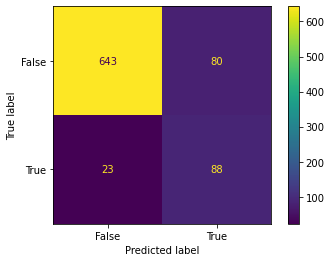

In [37]:
# evaluate the performance of the model
evaluate(gridsearch_dt, X_test, y_test)

On tuning the model, the model is performing better based on the recall score. However, the precision score is slightly low. There is a decrease in the difference between the train scores and the test scores(overfitting reduced).

### Random forest

Random forest is used since it is naturally resistant to noise and variance.

In [38]:
# create a pipeline
pipe_rf = Pipeline(steps=[('scale', StandardScaler()), ('rf', RandomForestClassifier(random_state=42))])
pipe_rf.fit(X_train_resampled, y_train_resampled)

Pipeline(steps=[('scale', StandardScaler()),
                ('rf', RandomForestClassifier(random_state=42))])

Recall_score: 
Train:  1.0
Test:  0.6666666666666666

Precision_score: 
Train:  1.0
Test:  0.6851851851851852

Accuracy_score: 
Train:  1.0
Test:  0.9148681055155875


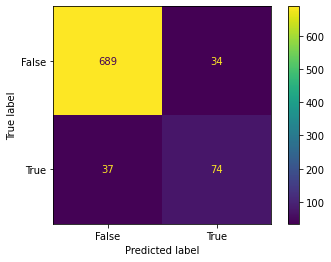

In [39]:
# evaluate model performance
evaluate(pipe_rf, X_test, y_test)

The random forest model has a higher recall compared to the baseline logistic regression model, but a lower recall compared to the decision tree model. <br>
The model is overfitting.

### Hyperparameter tuning of the random forest model

There are some parameters of random forest that can be tuned for the model’s better performance. This includes n_estimators, max_depth, min_samples_split, min_samples_leaf and max_features.

In [46]:
# hyperparameter tuning using GridSearchCV
params_rf = {'rf__n_estimators': range(400, 800, 200),
             'rf__criterion': ['gini', 'entropy'],
             'rf__max_depth': range(14, 20, 2),
             'rf__min_samples_split': range(3, 4, 7),
             'rf__min_samples_leaf': [5, 7, 12]
             
}

gridsearch_rf = GridSearchCV(pipe_rf, params_rf, cv=4, scoring='recall')
gridsearch_rf.fit(X_train_resampled, y_train_resampled)


GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('rf',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'rf__criterion': ['gini', 'entropy'],
                         'rf__max_depth': range(14, 20, 2),
                         'rf__min_samples_leaf': [5, 7, 12],
                         'rf__min_samples_split': range(3, 4, 7),
                         'rf__n_estimators': range(400, 800, 200)},
             scoring='recall')

In [47]:
# parameters that gave the best result
print(f'Optimal parameters: {gridsearch_rf.best_params_}')

# Mean cross-validated score of the best_estimator
print(f'Validation recall: {gridsearch_rf.best_score_}')

Optimal parameters: {'rf__criterion': 'entropy', 'rf__max_depth': 18, 'rf__min_samples_leaf': 5, 'rf__min_samples_split': 3, 'rf__n_estimators': 600}
Validation recall: 0.8702494229925095


Recall_score: 
Train:  0.9619181946403385
Test:  0.6756756756756757

Precision_score: 
Train:  0.9898403483309144
Test:  0.6696428571428571

Accuracy_score: 
Train:  0.9760225669957687
Test:  0.9124700239808153


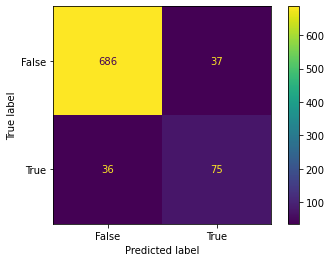

In [48]:
# evaluate the performance of the model
evaluate(gridsearch_rf, X_test, y_test)

On hyperparameter tuning, the recall increases by 1%. The model utilizes high computational power yet it performs poorly. Its performance is lower than the performance of the decision tree model.

## Model evaluation

Decision tree with tuned hyperparameters is the model with the best performance. The optimal parameters of the tuned model are: {'clf__criterion': 'entropy', 'clf__max_depth': 28, 'clf__max_features': 15, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2}<br>
The model has the highest recall score. The accuracy and precision scores are above average. <br>
However, the recall score achieved is below the set score of at least 85%.<br>
The evaluation metric values of the tuned decision tree are shown below:

In [40]:
# evaluation metrics of the best model based on the test data
print('DECISION TREE(TUNED) SCORES:')
print('Test Recall score: ', recall_score(y_test, gridsearch_dt.predict(X_test)))
print('Test Precision score: ', precision_score(y_test, gridsearch_dt.predict(X_test)))
print('Test Accuracy score: ', accuracy_score(y_test, gridsearch_dt.predict(X_test)))

DECISION TREE(TUNED) SCORES:
Test Recall score:  0.7927927927927928
Test Precision score:  0.5238095238095238
Test Accuracy score:  0.8764988009592326


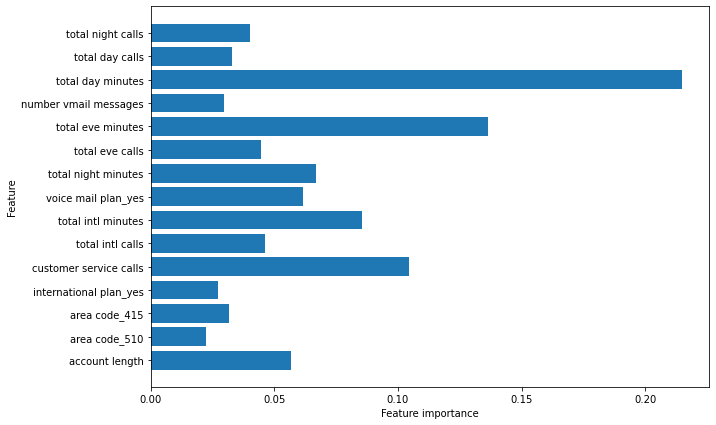

In [44]:
# plot feature importances of the best model using the defined function
# function takes in the pipeline name and figsize.
plot_feature_importances(gridsearch_dt.best_estimator_, (10,7))

## Conclusions and recommendations

The final model that will be used to predict customer churn is the decision tree with tuned hyperparameters.This model results in the lowest number of false negatives.<br>
The most important features for predicting customer churn are:
- total day minutes: total number of minutes the customer has been in calls during the day
- total evening minutes: total number of minutes the customer has been in calls during the evening
- customer service calls: number of calls the customer has made to customer service
- total international minutes: total number of minutes the user has been in international calls
 
Syriatel should ensure effective customer service so as to meet customers' expectations and analyze customer interactions. They can then follow up on both positive and negative feedbacks received.<br>
The more the number of minutes the customer spends on the phone, the higher the likelihood of not churning.  The company should look into the call charge rates in comparison to the competitors, and  consider if they should lower the charges of calls per minute. This can prevent other customers from churning.

## Next steps

The targeted recall score of 85% is not achieved by the best performing model. There is still some overfitting in the model irregardless of hyperparameter tuning.<br>
The training data size should be increased to reduce overfitting and hence improve model performance.